In [1]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [5]:
import collections

In [6]:
!pip install yfinance
clear_output()
import yfinance as yf

In [7]:
df = yf.download(tickers='TSLA')
df = df[-1000:]
df = df.reset_index(drop=True)
print(df.head())

[*********************100%***********************]  1 of 1 completed

         Open        High         Low       Close   Adj Close     Volume
0  118.866669  123.000000  113.836670  122.093330  122.093330  238397400
1  128.736664  132.996674  120.186668  123.779999  123.779999  254791800
2  127.313332  127.500000  120.166664  124.239998  124.239998  182152500
3  126.983330  140.000000  124.433334  139.873337  139.873337  249061800
4  145.520004  153.979996  143.566666  149.919998  149.919998  291894600


In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['Close'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции TSLA'
            ))
fig.show()

In [9]:
df['Close']

,Close
0,122.093330
1,123.779999
2,124.239998
3,139.873337
4,149.919998
...,...
995,220.320007
996,213.210007
997,209.210007
998,205.750000


In [10]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)
        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        elif action == 1:
            action = 0
        else:
            action = 1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now)
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = price_diff * action * coef
        # print(12121, reward)
        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [11]:
# Обратите внимание на то, что в RL часто используются совсем простые нейронные сети
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 10)
        self.fc2 = nn.Linear(10, action_shape)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = F.tanh(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Создадим экземпляр модели
        self.model = Net(state_shape, action_shape)

        # Создадим функцию ошибки
        self.criterion = nn.HuberLoss()
        # Добавим оптимизатор
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.0002)

    def save_experience(self, current_state, action, reward, next_state):
        """Метод для сохранения предудыщих данных эксперимента"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """Метод для оптимизации данных тренировки"""
        # Создаем фиксированную выборку из добавленных событий
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # Проходимся только по тем элементам, которые были добавлены в выборку

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # Получаем прогноз по следующему состоянию
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # Получаем прогноз по текущему состоянию
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # Уравнение Бэллмена
        # Суть в том, что мы берем максимально возможную награду
        # из действия из будущего шага (q_value_i_1) , умножаем ее на гамму
        # (коэф. значимости будущих наград), прибавляем к текущей награде
        for i in range(len(indices_sampled)):
            # и заносим в Q таблицу для обучения
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [13]:
# Количество эпох обучения
epochs = 100
# Коэф. значимости награды на шаг вперед
gamma = 0.9
# Количество эпох обучения
epsilon = 0.95

In [14]:
# Размер датасета
DATASET_LENGTH = len(df['Close'])
# Размер окна из которого будут браться предыдущие данные
WINDOW_SHAPE = 40
# Шаг предыдущих данных
REWARD_TIME = 1
# Число доступных действий
ACTIONS_SHAPE = 3
# Размер выборки
SAMPLE_SIZE = 100


In [15]:
action_to_backtest_action = {
    2: 1,  # покупаем
    1: 0,  # держим
    0: -1,  # продаем
}

In [16]:
train_dataset = np.array(df['Close'][:-50])
test_dataset = np.array(df['Close'][-50:])

In [17]:
# Прописываем новую среду и передаем данные о закрытии цены
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [18]:
set_random_seed(42)


for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    epsilon = 1.0 / (i+1)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 21.144864425407384
Epoch 1 ... 47.794673571361045
Epoch 2 ... 34.12397949084459
Epoch 3 ... 57.760558847022395
Epoch 4 ... 110.75431059951698
Epoch 5 ... 136.7099866877557
Epoch 6 ... 138.99743612056517
Epoch 7 ... 131.56034849395584
Epoch 8 ... 98.1122359977697
Epoch 9 ... 134.916794444337
Epoch 10 ... 132.77341467056863
Epoch 11 ... 152.5596064702906
Epoch 12 ... 170.5053533002226
Epoch 13 ... 176.75285381321336
Epoch 14 ... 158.48260256323485
Epoch 15 ... 162.32784426513942
Epoch 16 ... 159.1166295889843
Epoch 17 ... 161.0194660518298
Epoch 18 ... 170.02092367745075
Epoch 19 ... 165.42209671406593
Epoch 20 ... 191.862862128498
Epoch 21 ... 183.60213813739773
Epoch 22 ... 169.0264140549797
Epoch 23 ... 172.65237906847327
Epoch 24 ... 167.71179803527227
Epoch 25 ... 174.56362716960172
Epoch 26 ... 173.46572875976562
Epoch 27 ... 176.71837969319392
Epoch 28 ... 165.9868045215166
Epoch 29 ... 181.51085143304368
Epoch 30 ... 194.2666233176052
Epoch 31 ... 188.37917818881496
E

In [19]:
actions = []

for j in range(WINDOW_SHAPE, len(df['Close']), REWARD_TIME):
    # 1. Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

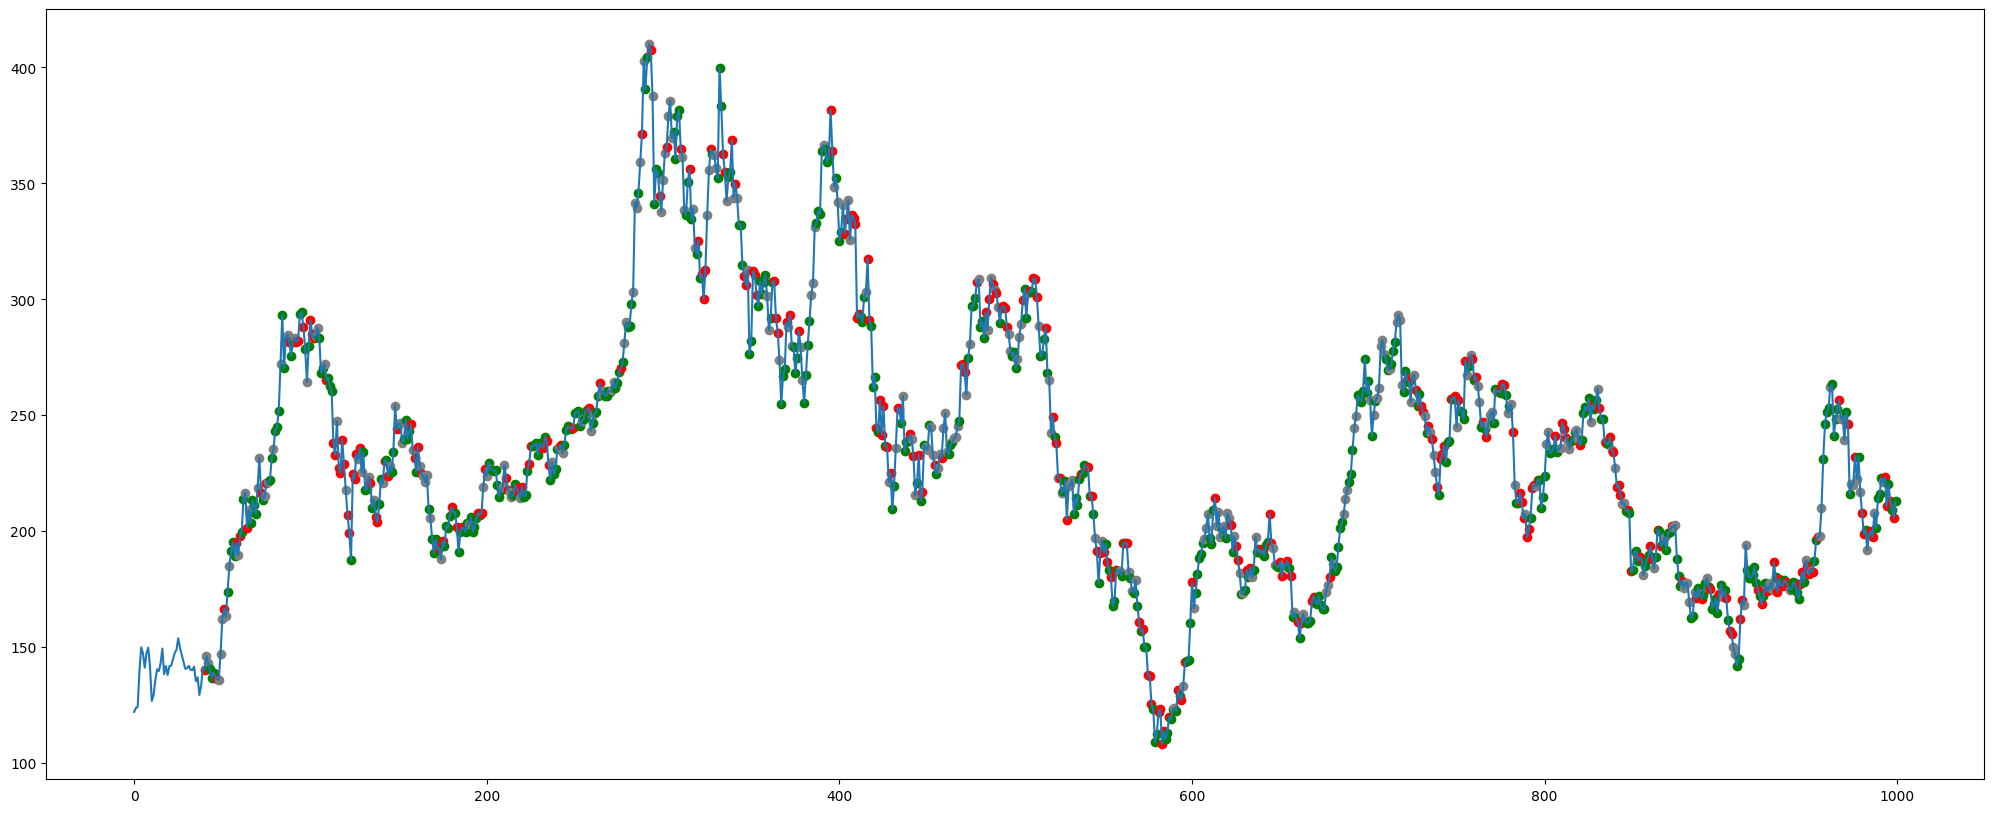

In [20]:
plt.figure(figsize = (25, 10))
plt.plot(environment.data)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')
    else:
        plt.scatter(e, environment.data[e], color = 'grey')
plt.show()

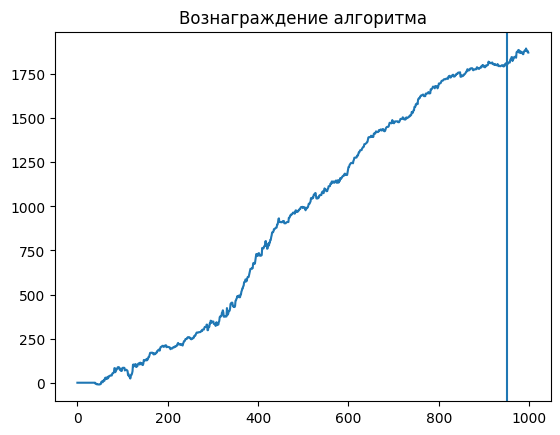

In [21]:
 # Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment.data.flatten(),
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')

plt.axvline(x=950)
plt.show()